<a href="https://colab.research.google.com/github/liyaSileshi/amharic-sentiment-analysis/blob/main/tweet_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
pd.options.mode.chained_assignment = None
import re

## Downloading the dataset

In [2]:
url = "https://raw.githubusercontent.com/liyaSileshi/amharic-sentiment-analysis/main/data_preprocess/test.csv"
df_test = pd.read_csv(url)
df_test

,Unnamed: 0,tweet_id,sentiment,tweet
0,0,1213842050455654402,neutral,@Haymana_ እንደዛ ካልሆነ በስተቀር ሰውዬው ማንንም አይቦልኩም
1,1,1215480766295171072,neutral,NaN
2,2,1222950264812064768,positive,ለመገናኛ ብዙሃን አባላት!\n\nበደምቢዶሎ የታገቱ ኢትዮጵያውያን ድምፅ ለ...
3,3,1213967203076395009,negative,NaN
4,4,1213961696840171521,neutral,NaN
...,...,...,...,...
934,934,1214922390469324802,neutral,@degu_zerihun የውስጥ ሰለማችን መጠበቅ፣ የልማታችን ሁሉ ወሳኝ ማ...
935,935,1214922390469324802,neutral,@degu_zerihun የውስጥ ሰለማችን መጠበቅ፣ የልማታችን ሁሉ ወሳኝ ማ...
936,936,1223053757883260928,positive,"""አዲሱ መንግስት""ና ህገ-መንግስታዊነት - ረዥም ገመድ\n\nህገ-መንግስታ..."
937,937,1213771045070659584,negative,@TeameYitbarek @Ze_Astegoma @eskinder_nega ትግሬ...


In [3]:
url = "https://raw.githubusercontent.com/liyaSileshi/amharic-sentiment-analysis/main/data_preprocess/train.csv"
df_train = pd.read_csv(url)
df_train

,Unnamed: 0,tweet_id,sentiment,tweet
0,0,1213084822521950209,neutral,NaN
1,1,1213011490372038656,neutral,ልዩ የተፈጥሮ ገፅታ \n *****\n\nየምስራቅ አፍሪካ የውሃ ማማ ጮቄ
2,2,1213763702715043840,mixed,@AbbaSheger ማንም ቢሆን የሀገሩን ጥቅም አሳልፎ አይሰጥም። ያ መላ...
3,3,1213764224356421633,neutral,ብ/ጄ አሳምነው ጽጌ ከምክትል ጠ/ሚ ደመቀ ጋር በሱዳን ጉብኝት አልበሽር ...
4,4,1212766574337150976,positive,NaN
...,...,...,...,...
7506,7506,1212925000610721792,neutral,ሙስናውና የመልካም አስተዳዳር እጦቱ በእጅጉ እጨመረ ነው።
7507,7507,1201475433780219904,negative,የብልጽግናን ፓርቲ ፊርማ ከፈረሙት መካከል የኦርቶዶክስ ተዋህዶ አማኞች የ...
7508,7508,1212741943412822016,positive,1ኛ የጴጥሮስ መልእክት-1 Peter :1\n 23 ዳግመኛ የተወለዳችሁት ከ...
7509,7509,1213033524766351360,negative,@ChobinaAtlas @hymelee @AbbaSheger ማነን: ስንት በር...


In [4]:
url = "https://raw.githubusercontent.com/liyaSileshi/amharic-sentiment-analysis/main/data_preprocess/dev.csv"
df_valid = pd.read_csv(url)
df_valid

,Unnamed: 0,tweet_id,sentiment,tweet
0,0,1214005466675777536,neutral,RT @AyeleGelan: ድሮ ተሸምድደው በቀላሉ ይንበለበሉ የነበሩ ኢህኣ...
1,1,1213261378397409280,mixed,ኦሮሞ ልምድ የለውም ካልን ሌላውም ያው ይሆናል ዋናውነገር ፍትህን ማውረድ...
2,2,1213846984349626369,neutral,እስክንድር ነጋ ባለአደራው ምክርቤት ለአንድ ብሄር እና ለአንድ ሃይማኖት ...
3,3,1216365312561635333,positive,@Gfasil በረከት በላይነህ \nየእያዪ ፈንገስ ትያትር ደራሲ\nእንዲሁም...
4,4,1213234381768265728,neutral,NaN
...,...,...,...,...
934,934,1214096434989031425,positive,@HaileFida ምሳሌ 11 (Proverbs)\n2፤ ትዕቢት ከመጣች ውርደ...
935,935,1213850051866324998,negative,@isuchisu በተንኮል በጠባብ ዘረኝነት የተመረዘውን ልብህን አፅዳ ከ...
936,936,1214678524746981383,positive,"@noctivwgus ሀሳቡ እርስዎን ለማስጨነቅ አልነበረም, በእውነቱ። እኔ..."
937,937,1213120677743599618,positive,@_wurye @_wurye ❤ I'm inlove with this song 🎵\...


## Data Pre-Processing and Cleaning

In [5]:
def clean_df(df):
  """removes null values and resets index"""
  # remove null values from dataset
  df = df.dropna()
  #drop repeated rows (drop rows with similar tweet id)
  df = df.drop_duplicates(subset='tweet_id', keep="first")
  df = df.reset_index(drop=True)
  return df

df_test = clean_df(df_test)
df_train = clean_df(df_train)
df_valid = clean_df(df_valid)

In [6]:
def clean_text(row, options):
    """Removes url, mentions, emoji and uppercase from tweets"""
    if options['lowercase']:
        row = row.lower()

    # if options['decode_html']:
    #     txt = BeautifulSoup(row, 'lxml')
    #     row = txt.get_text()

    if options['remove_url']:
        # row = row.replace('http\S+|www.\S+', '')
        row = re.sub(r"(?:\@|https?\://)\S+", "", row)

    if options['remove_mentions']:
        row = re.sub("@[A-Za-z0-9_]+","", row)

    if options['demojify']:
      emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
      row = re.sub(emoj, '', row)

    return row

clean_config = {
    'remove_url': True,
    'remove_mentions': True,
    # 'decode_utf8': True,
    'lowercase': True,
    'demojify': True
    }

df_test['tweet'] = df_test['tweet'].apply(clean_text, args=(clean_config,))
df_train['tweet'] = df_train['tweet'].apply(clean_text, args=(clean_config,))
df_valid['tweet'] = df_valid['tweet'].apply(clean_text, args=(clean_config,))

In [7]:
df_train['tweet']

0           ልዩ የተፈጥሮ ገፅታ \n *****\n\nየምስራቅ አፍሪካ የውሃ ማማ ጮቄ
1        ማንም ቢሆን የሀገሩን ጥቅም አሳልፎ አይሰጥም። ያ መላጣ (ነአ) የሻቢይ...
2       ብ/ጄ አሳምነው ጽጌ ከምክትል ጠ/ሚ ደመቀ ጋር በሱዳን ጉብኝት አልበሽር ...
3        the only part i like......"ትልልቅ የነዳጅ ፍጆታ ያላቸው...
4           እሺ ወንድሜ እተከላለሁ ማኛ እኮ ናት ወዳታለሁ በጣም ደሞ  ቅና አሉህ 
                              ...                        
6269                 ሙስናውና የመልካም አስተዳዳር እጦቱ በእጅጉ እጨመረ ነው።
6270    የብልጽግናን ፓርቲ ፊርማ ከፈረሙት መካከል የኦርቶዶክስ ተዋህዶ አማኞች የ...
6271    1ኛ የጴጥሮስ መልእክት-1 peter :1\n 23 ዳግመኛ የተወለዳችሁት ከ...
6272       ማነን: ስንት በርሀብ እየሞተ ባለባት ሀገር ስለ ጦርነት የምናወራው:...
6273    ታናሽ ወንድሜ abrham የመጀመርያውን አዲስ  ነጠላ ዜማ ይዞ እየመጣ ነ...
Name: tweet, Length: 6274, dtype: object

In [8]:
df_valid

,Unnamed: 0,tweet_id,sentiment,tweet
0,0,1214005466675777536,neutral,rt ድሮ ተሸምድደው በቀላሉ ይንበለበሉ የነበሩ ኢህኣዴግ ልብ ወለድ ድር...
1,1,1213261378397409280,mixed,ኦሮሞ ልምድ የለውም ካልን ሌላውም ያው ይሆናል ዋናውነገር ፍትህን ማውረድ...
2,2,1213846984349626369,neutral,እስክንድር ነጋ ባለአደራው ምክርቤት ለአንድ ብሄር እና ለአንድ ሃይማኖት ...
3,3,1216365312561635333,positive,በረከት በላይነህ \nየእያዪ ፈንገስ ትያትር ደራሲ\nእንዲሁም ገራሚ ገጣ...
4,5,1213881132057595907,negative,የአብይ ተላላኪና ጉዳይ አስፈፃሚ እንዳይሆን እንጂ ሌላዉስ ችግር የለዉም
...,...,...,...,...
797,934,1214096434989031425,positive,ምሳሌ 11 (proverbs)\n2፤ ትዕቢት ከመጣች ውርደት ትመጣለች፤ በ...
798,935,1213850051866324998,negative,በተንኮል በጠባብ ዘረኝነት የተመረዘውን ልብህን አፅዳ ከዚያ ለአላህ ስ...
799,936,1214678524746981383,positive,"ሀሳቡ እርስዎን ለማስጨነቅ አልነበረም, በእውነቱ። እኔን እንደማታጠቃኝ ..."
800,937,1213120677743599618,positive,i'm inlove with this song \nያንተ ፊት ተከብሎኛል እ...


In [9]:
df_test

,Unnamed: 0,tweet_id,sentiment,tweet
0,0,1213842050455654402,neutral,እንደዛ ካልሆነ በስተቀር ሰውዬው ማንንም አይቦልኩም
1,2,1222950264812064768,positive,ለመገናኛ ብዙሃን አባላት!\n\nበደምቢዶሎ የታገቱ ኢትዮጵያውያን ድምፅ ለ...
2,5,1213760822964609024,positive,የምወድሽ፣\nየምሳሳልሽ፣\nእናቴ፣\nሃገሬ፣ \nኢትዮጵያ!\nከላይ አረንጓ...
3,6,1201134046862094336,positive,rt የዚህ ቤት ከፍለን የማንጨርሰው ውለታ አለብን \nthe best pl...
4,7,1214129980306808834,neutral,ልሙጦቹ ... ደግሞ ምን ይደረግላችሁ በበአሉ?
...,...,...,...,...
547,931,1216256678808735744,neutral,• ከታች ያለው አማራ ክልል ነው! እዚያ አዲሥ ናቸው መሠለኝ ብሩን እያተ...
548,933,1214922390469324802,neutral,የውስጥ ሰለማችን መጠበቅ፣ የልማታችን ሁሉ ወሳኝ ማዕከል ነው። የሰላም ...
549,936,1223053757883260928,positive,"""አዲሱ መንግስት""ና ህገ-መንግስታዊነት - ረዥም ገመድ\n\nህገ-መንግስታ..."
550,937,1213771045070659584,negative,ትግሬ ማለትህ ነው በምቀኝነት የገማቹህ ህዝቦች አናሳ


## Character level normalization

In [10]:
#character level normalization

import re
#method to normalize character level missmatch such as ጸሀይ and ፀሐይ
def normalize_char_level_missmatch(input_token):
    rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
    rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
    rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
    rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
    rep5=re.sub('[ሕኅ]','ህ',rep4)
    rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
    rep7=re.sub('[ሠ]','ሰ',rep6)
    rep8=re.sub('[ሡ]','ሱ',rep7)
    rep9=re.sub('[ሢ]','ሲ',rep8)
    rep10=re.sub('[ሣ]','ሳ',rep9)
    rep11=re.sub('[ሤ]','ሴ',rep10)
    rep12=re.sub('[ሥ]','ስ',rep11)
    rep13=re.sub('[ሦ]','ሶ',rep12)
    rep14=re.sub('[ዓኣዐ]','አ',rep13)
    rep15=re.sub('[ዑ]','ኡ',rep14)
    rep16=re.sub('[ዒ]','ኢ',rep15)
    rep17=re.sub('[ዔ]','ኤ',rep16)
    rep18=re.sub('[ዕ]','እ',rep17)
    rep19=re.sub('[ዖ]','ኦ',rep18)
    rep20=re.sub('[ጸ]','ፀ',rep19)
    rep21=re.sub('[ጹ]','ፁ',rep20)
    rep22=re.sub('[ጺ]','ፂ',rep21)
    rep23=re.sub('[ጻ]','ፃ',rep22)
    rep24=re.sub('[ጼ]','ፄ',rep23)
    rep25=re.sub('[ጽ]','ፅ',rep24)
    rep26=re.sub('[ጾ]','ፆ',rep25)
    #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል  
    rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
    rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
    rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
    rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
    rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
    rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
    rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
    rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
    rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
    rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
    rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
    rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
    rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
    rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
    rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
    rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
    rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
    rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
    rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
    rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
    rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
    rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ  
    return rep48

In [11]:
df_test['tweet'] = df_test['tweet'].apply(lambda x: normalize_char_level_missmatch(x))
df_train['tweet'] = df_train['tweet'].apply(lambda x: normalize_char_level_missmatch(x))
df_valid['tweet'] = df_valid['tweet'].apply(lambda x: normalize_char_level_missmatch(x))

# Model 1: Using Naive Bayes model and count vectorizer

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import sys

In [13]:
# put values of tweet and label in variables
X_train, y_train = df_train['tweet'].values, df_train['sentiment'].values
X_test, y_test = df_test['tweet'].values, df_test['sentiment'].values

In [14]:
df_train.sentiment.unique()

array(['neutral', 'mixed', 'negative', 'positive'], dtype=object)

In [ ]:
#change text to vector using count vectorizer and scale

matrix = CountVectorizer(analyzer='word',max_features=1000, ngram_range=(1, 3))
X_train.shape
X_train = matrix.fit_transform(X_train).toarray() #scaling
X_test = matrix.fit_transform(X_test).toarray()
np.set_printoptions(threshold=sys.maxsize)

for i in range(2):
  print(X_train[i])


In [17]:
# Naive Bayes 
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

In [18]:
# Predict Class
y_pred = classifier.predict(X_test)

In [19]:
# Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.21739130434782608

A very low accuracy of 21.7%

###Classification report and confusion matrix

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['neutral', 'mixed', 'negative', 'positive']))

              precision    recall  f1-score   support

     neutral       0.07      0.30      0.12        50
       mixed       0.26      0.16      0.19       141
    negative       0.42      0.26      0.32       246
    positive       0.18      0.17      0.18       115

    accuracy                           0.22       552
   macro avg       0.23      0.22      0.20       552
weighted avg       0.30      0.22      0.24       552



# Model 2: Naive Bayes model with TFIDF vectorizer

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
# put values of tweet and label in variables
X_train, y_train = df_train['tweet'].values, df_train['sentiment'].values
X_test, y_test = df_test['tweet'].values, df_test['sentiment'].values

In [37]:
matrix = TfidfVectorizer(analyzer='word',max_features=1000, ngram_range=(1, 3))
X_train = matrix.fit_transform(X_train).toarray() #scaling
X_test = matrix.fit_transform(X_test).toarray()
np.set_printoptions(threshold=sys.maxsize)

In [38]:
# for i in range(2):
#   print(X_train[i])

##  Initialize and train the model

In [39]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

## Make a prediction

In [40]:
y_pred = classifier.predict(X_test)

## Calculate the accuracy

In [41]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.21557971014492755

Still...a very low accuracy of 21.5%

# Model 3: Text blob sentiment

In [80]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report

In [97]:
class Base:
    """Base class that houses common utilities for reading in test data
    and calculating model accuracy and F1 scores.
    """
    def __init__(self) -> None:
        pass

    def read_data(self, fname: str, lower_case: bool=False,
                  colnames=['truth', 'text']) -> pd.DataFrame:
        "Read in test data into a Pandas DataFrame"
        df = pd.read_csv(fname, sep='\t', header=None, names=colnames)
        df['truth'] = df['truth'].str.replace('__label__', '')
        # Categorical data type for truth labels
        df['truth'] = df['truth'].astype(int).astype('category')

        # Optional lowercase for test data (if model was trained on lowercased text)
        if lower_case:
            df['text'] = df['text'].str.lower()
        return df

    def accuracy(self, df: pd.DataFrame) -> None:
        "Prediction accuracy (percentage) and F1 score"

        acc = accuracy_score(df['sentiment'], df['pred'])*100
        f1 = f1_score(df['sentiment'], df['pred'], average='macro')*100

        recall = recall_score(df['sentiment'], df['pred'], average='macro')*100
        precision = precision_score(df['sentiment'], df['pred'], average='macro')*100
        newf1 = 2 * recall * precision / (recall + precision)

        df.to_csv("result.csv",index = False)

        print(len(df))
   #     print("Truth: ", df['truth'].tolist())
    #    print("predicted: ", df['pred'].tolist())
        print(
            "Accuracy: {:.3f}\nMacro F1-score: {:.3f}\nMacro recall: {:.3f}\nMacro precission: {:.3f}\nNew F1 MAcro: {:.3f}".format(
                acc, f1, recall, precision, newf1))
        print("{:.2f} & {:.2f} & {:.2f} & {:.2f}".format(acc, recall, precision, newf1))

In [98]:
class TextBlobSentiment(Base):
    """Predict sentiment scores using TextBlob.
    https://textblob.readthedocs.io/en/dev/
    """
    def __init__(self, model_file: str=None) -> None:
        super().__init__()

    def score(self, text: str) -> float:
        # pip install textblob
        from textblob import TextBlob
        return TextBlob(text).sentiment.polarity

    def predict(self, df_train, df_test, lower_case: bool) -> pd.DataFrame:
    # def predict(self, train_file: None, test_file: str, lower_case: bool) -> pd.DataFrame:
        # df = self.read_data(test_file, lower_case)
        df_test['score'] = df_test['tweet'].apply(self.score)
        # Convert float score to category based on binning
        df_test['pred'] = pd.cut(df_test['score'],
                            bins=3,
                            labels=["negative", "neutral", "positive"])
        df = df_test.drop('score', axis=1)
        return df

In [99]:
text_blob = TextBlobSentiment()


In [100]:
# drop "mixed" sentiment from df train and df_test
df_train = df_train[df_train["sentiment"].str.contains("mixed")==False]
df_test = df_test[df_test["sentiment"].str.contains("mixed")==False]

In [101]:
result = text_blob.predict(df_train, df_test, True)


In [103]:
text_blob.accuracy(result)

502
Accuracy: 46.215
Macro F1-score: 22.923
Macro recall: 31.947
Macro precission: 35.774
New F1 MAcro: 33.752
46.22 & 31.95 & 35.77 & 33.75


# Tokenization

In [ ]:
from nltk.tokenize import word_tokenize
df_test['tweet'] = df_test['tweet'].apply(word_tokenize)

https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/TEXT_PREPROCESSING.ipynb#scrollTo=hm2G1yAsHTGH

In [ ]:
# import com.johnsnowlabs.nlp.DocumentAssembler
# import com.johnsnowlabs.nlp.annotator.NorvigSweetingModel
# import com.johnsnowlabs.nlp.annotators.Tokenizer
# import org.apache.spark.ml.Pipeline
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

In [ ]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline


In [ ]:
#initialize spark context
spark = sparknlp.start()


https://www.kdnuggets.com/2019/11/spark-nlp-101-lightpipeline.html
fullAnnotate() returns the content and metadata in Annotation type. According to documentation, the Annotation type has the following attributes:
```
annotatorType: String, 
begin: Int, 
end: Int, 
result: String, (this is what annotate returns)
metadata: Map[String, String], 
embeddings: Array[Float]
```

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer()\
        .setInputCols("document")\
        .setOutputCol("token")

lemmatizer = LemmatizerModel.pretrained("lemma", "am") \
        .setInputCols(["token"]) \
        .setOutputCol("lemma")

nlp_pipeline = Pipeline(stages=[document_assembler, tokenizer, lemmatizer])
light_pipeline = LightPipeline(nlp_pipeline.fit(spark.createDataFrame([[""]]).toDF("text")))
results = light_pipeline.fullAnnotate(["መጽሐፉን መጽሐፍ ኡ ን አስያዛት አስያዝ ኧ ኣት መጽሐፍ ።"])

lemma download started this may take some time.
Approximate size to download 36 KB
[OK!]


In [ ]:
results[0]['document']

[Annotation(document, 0, 36, መጽሐፉን መጽሐፍ ኡ ን አስያዛት አስያዝ ኧ ኣት መጽሐፍ ።, {})]

In [ ]:
#extracting the result from the metadata
results[0]['document'][0].result

'መጽሐፉን መጽሐፍ ኡ ን አስያዛት አስያዝ ኧ ኣት መጽሐፍ ።'

In [ ]:
results[0]['token']

[Annotation(token, 0, 4, መጽሐፉን, {'sentence': '0'}),
 Annotation(token, 6, 9, መጽሐፍ, {'sentence': '0'}),
 Annotation(token, 11, 11, ኡ, {'sentence': '0'}),
 Annotation(token, 13, 13, ን, {'sentence': '0'}),
 Annotation(token, 15, 19, አስያዛት, {'sentence': '0'}),
 Annotation(token, 21, 24, አስያዝ, {'sentence': '0'}),
 Annotation(token, 26, 26, ኧ, {'sentence': '0'}),
 Annotation(token, 28, 29, ኣት, {'sentence': '0'}),
 Annotation(token, 31, 34, መጽሐፍ, {'sentence': '0'}),
 Annotation(token, 36, 36, ።, {'sentence': '0'})]

In [ ]:
results[0]['lemma']

[Annotation(token, 0, 4, _, {'sentence': '0'}),
 Annotation(token, 6, 9, መጽሐፍ, {'sentence': '0'}),
 Annotation(token, 11, 11, ኡ, {'sentence': '0'}),
 Annotation(token, 13, 13, ን, {'sentence': '0'}),
 Annotation(token, 15, 19, _, {'sentence': '0'}),
 Annotation(token, 21, 24, አስያዝ, {'sentence': '0'}),
 Annotation(token, 26, 26, ኧ, {'sentence': '0'}),
 Annotation(token, 28, 29, ኣት, {'sentence': '0'}),
 Annotation(token, 31, 34, መጽሐፍ, {'sentence': '0'}),
 Annotation(token, 36, 36, ።, {'sentence': '0'})]

# Create wordcloud

In [ ]:
!pip3 install langdetect

In [ ]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
# import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def create_wordcloud(text):
#  mask = np.array(Image.open("cloud.png"))
 stopwords = set(STOPWORDS)
 wc = WordCloud(background_color="white",
#  mask = mask,
 max_words=3000,
 stopwords=stopwords,
 repeat=True)
 wc.generate(str(text))
 wc.to_file("wc.png")
 print("Word Cloud Saved Successfully")
 path="wc.png"
 display(Image.open(path))



Word Cloud Saved Successfully


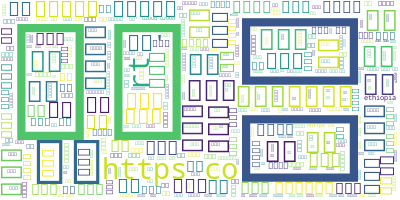

In [ ]:
#Creating wordcloud for all tweets
create_wordcloud(df_test["tweet"].values)

text vectorization on amharic dataset

In [ ]:
def run_classifier(files: Tuple[str, str, str],
                   method: str,
                   method_class: Base,
                   model_file: str,
                   lower_case: bool) -> None:
    "Inherit classes from classifiers.py and apply the predict/accuracy methods"
    train, dev, test = files  # Unpack train, dev and test filenames
    result = method_class.predict(train, test, lower_case)
    method_class.accuracy(result)
    # Plot confusion matrix
    make_dirs("Plots")
    fig, ax = plot_confusion_matrix(result['truth'], result['pred'], normalize=True)
    ax.set_title("Normalized Confusion Matrix: {}".format(method.title()))
    fig.tight_layout()
    fig.savefig("Plots/{}.png".format(method))